In [2]:
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import re
import matplotlib.pyplot as plt
import os
import random

# 全局参数设置
BATCH_SIZE = 32
NUM_EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
def set_seed(seed):
    torch.manual_seed(seed)               # CPU随机种子
    torch.cuda.manual_seed(seed)          # GPU随机种子
    torch.cuda.manual_seed_all(seed)      # 多个GPU
    np.random.seed(seed)                  # numpy随机种子
    random.seed(seed)                     # Python随机种子
    torch.backends.cudnn.deterministic = True   # 保证每次结果一样
    torch.backends.cudnn.benchmark = False      # 禁用优化（可能引入非确定性）

set_seed(44)

In [5]:

class SongDataset(Dataset):
    def __init__(self, df, continuous_cols,categorical_cols):
        self.audio_continuous = df[continuous_cols].values.astype(np.float32)
        self.audio_categorical = df[categorical_cols].values.astype(np.float32)
        self.audio = np.concatenate([self.audio_continuous, self.audio_categorical], axis=1)
        self.labels = df["label"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio_tensor = torch.FloatTensor(self.audio[idx])
        label_tensor = torch.LongTensor([self.labels[idx]])
        return audio_tensor, label_tensor

def collate_fn(batch):
    audios, labels = zip(*batch)
    return torch.stack(audios), torch.cat(labels)


In [6]:

class AUDIO_MLP(nn.Module):
    def __init__(self, audio_feat_dim, num_classes,
                 audio_hidden_dims=(64, 32), fc_hidden=128):
        super().__init__()
        audio_layers = []
        input_dim = audio_feat_dim
        for hidden_dim in audio_hidden_dims:
            audio_layers.append(nn.Linear(input_dim, hidden_dim))
            audio_layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.audio_mlp = nn.Sequential(*audio_layers)

        self.fc = nn.Sequential(
            nn.Linear(input_dim, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )

    def forward(self, audio):
        audio_out = self.audio_mlp(audio)
        return self.fc(audio_out)


In [7]:

# def prepare_data(df, continuous_cols,categorical_cols, test_size=0.2, val_size=0.1):
#     df = df.copy()
#     label_encoder = LabelEncoder()
#     df["label"] = label_encoder.fit_transform(df["playlist_genre"])
#     num_classes = len(label_encoder.classes_)

#     train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df["label"], random_state=42)
#     train_df, val_df = train_test_split(train_val_df, test_size=val_size, stratify=train_val_df["label"], random_state=42)

#     train_dataset = SongDataset(train_df, continuous_cols,categorical_cols)
#     val_dataset = SongDataset(val_df, continuous_cols,categorical_cols)
#     test_dataset = SongDataset(test_df, continuous_cols,categorical_cols)

#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#     audio_feat_dim = len(continuous_cols)+len(categorical_cols)

#     return train_loader, val_loader, test_loader, num_classes, label_encoder,audio_feat_dim

def prepare_data(train_df,test_df, continuous_cols,categorical_cols,val_size=0.1):
    label_encoder = LabelEncoder()
    train_df["label"] = label_encoder.fit_transform(train_df["playlist_genre"])
    test_df["label"] = label_encoder.fit_transform(test_df["playlist_genre"])
    num_classes = len(label_encoder.classes_)

    train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df["label"], random_state=42)

    train_dataset = SongDataset(train_df, continuous_cols,categorical_cols)
    val_dataset = SongDataset(val_df, continuous_cols,categorical_cols)
    test_dataset = SongDataset(test_df, continuous_cols,categorical_cols)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    audio_feat_dim = len(continuous_cols)+len(categorical_cols)

    return train_loader, val_loader, test_loader, num_classes, label_encoder,audio_feat_dim

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for audio, labels in dataloader:
        audio, labels = audio.to(DEVICE), labels.to(DEVICE)
        outputs = model(audio)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, total_correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for audio, labels in dataloader:
            audio, labels = audio.to(DEVICE), labels.to(DEVICE)
            outputs = model(audio)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / total, total_correct / total, all_preds, all_labels


In [8]:

def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=1e-3, early_stop_patience=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Acc = {train_acc:.4f} | Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            print(f"Best model saved at epoch {epoch}")
            torch.save(model.state_dict(), EPOCH_MODEL_PATH)
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break
    return history,best_val_acc

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.tight_layout()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test_model(model, test_loader, label_encoder,title,output_csv_path):
    criterion = nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.to(DEVICE)

    # 评估模型
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion)

    # 打印指标
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(labels, preds, target_names=label_encoder.classes_))

    # 打印混淆矩阵
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # 打印模型参数量
    num_params = count_parameters(model)
    print(f"Number of trainable parameters: {num_params:,}")
    # 保存每条预测到CSV
    decoded_preds = label_encoder.inverse_transform(preds)
    output_data = {
        "Predicted Label": decoded_preds
    }

    df_output = pd.DataFrame(output_data)
    df_output.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")


In [9]:
# === 主流程入口 ===

# 1. 读取数据
# df = pd.read_csv("/content/drive/MyDrive/CS5242_Song_Prediction/cleaned_spotify_songs_v2.csv")
train_df = pd.read_csv("/content/drive/MyDrive/CS5242_Song_Prediction/Final_cleaned_dataset/train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CS5242_Song_Prediction/Final_cleaned_dataset/test_df.csv")
# 提取连续变量的列名（float 和 int 类型）
continuous_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# 提取分类变量的列名（bool 类型）
categorical_cols = train_df.select_dtypes(include=['bool']).columns.tolist()


# 2. 准备数据
# train_loader, val_loader, test_loader, num_classes, label_encoder,audio_feat_dim = prepare_data(df, continuous_cols,categorical_cols)
train_loader, val_loader, test_loader, num_classes, label_encoder,audio_feat_dim = prepare_data(train_df,test_df, continuous_cols,categorical_cols)


Trying config: {'audio_hidden_dims': (32, 16), 'fc_hidden': 64}
Epoch 1: Train Loss = 1.4553, Acc = 0.4310 | Val Loss = 1.3320, Acc = 0.4846
Best model saved at epoch 1
Epoch 2: Train Loss = 1.2935, Acc = 0.5006 | Val Loss = 1.3021, Acc = 0.4801
Epoch 3: Train Loss = 1.2726, Acc = 0.5127 | Val Loss = 1.2948, Acc = 0.5064
Best model saved at epoch 3
Epoch 4: Train Loss = 1.2625, Acc = 0.5157 | Val Loss = 1.2855, Acc = 0.5139
Best model saved at epoch 4
Epoch 5: Train Loss = 1.2547, Acc = 0.5215 | Val Loss = 1.2754, Acc = 0.5019
Epoch 6: Train Loss = 1.2465, Acc = 0.5231 | Val Loss = 1.2705, Acc = 0.5109
Epoch 7: Train Loss = 1.2411, Acc = 0.5223 | Val Loss = 1.2723, Acc = 0.5139
Early stopping triggered.
Best model updated.


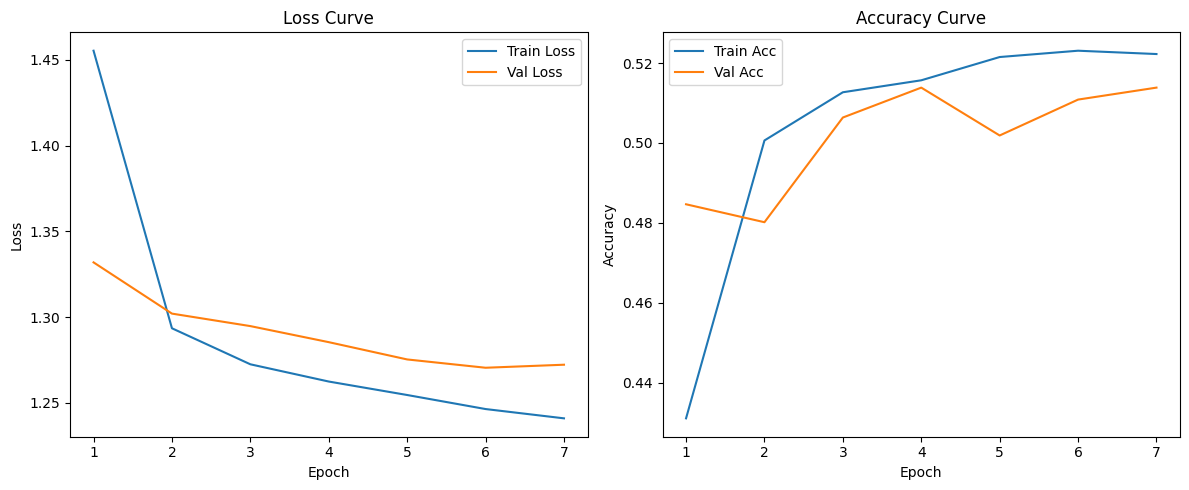

Trying config: {'audio_hidden_dims': (64, 32), 'fc_hidden': 128}
Epoch 1: Train Loss = 1.3956, Acc = 0.4603 | Val Loss = 1.2960, Acc = 0.4989
Best model saved at epoch 1
Epoch 2: Train Loss = 1.2702, Acc = 0.5095 | Val Loss = 1.2763, Acc = 0.5094
Best model saved at epoch 2
Epoch 3: Train Loss = 1.2485, Acc = 0.5230 | Val Loss = 1.2600, Acc = 0.5176
Best model saved at epoch 3
Epoch 4: Train Loss = 1.2359, Acc = 0.5286 | Val Loss = 1.2513, Acc = 0.5131
Epoch 5: Train Loss = 1.2295, Acc = 0.5283 | Val Loss = 1.2669, Acc = 0.5176
Epoch 6: Train Loss = 1.2228, Acc = 0.5342 | Val Loss = 1.2492, Acc = 0.5213
Best model saved at epoch 6
Epoch 7: Train Loss = 1.2178, Acc = 0.5322 | Val Loss = 1.2448, Acc = 0.5176
Epoch 8: Train Loss = 1.2137, Acc = 0.5358 | Val Loss = 1.2504, Acc = 0.5206
Epoch 9: Train Loss = 1.2092, Acc = 0.5368 | Val Loss = 1.2396, Acc = 0.5206
Early stopping triggered.
Best model updated.


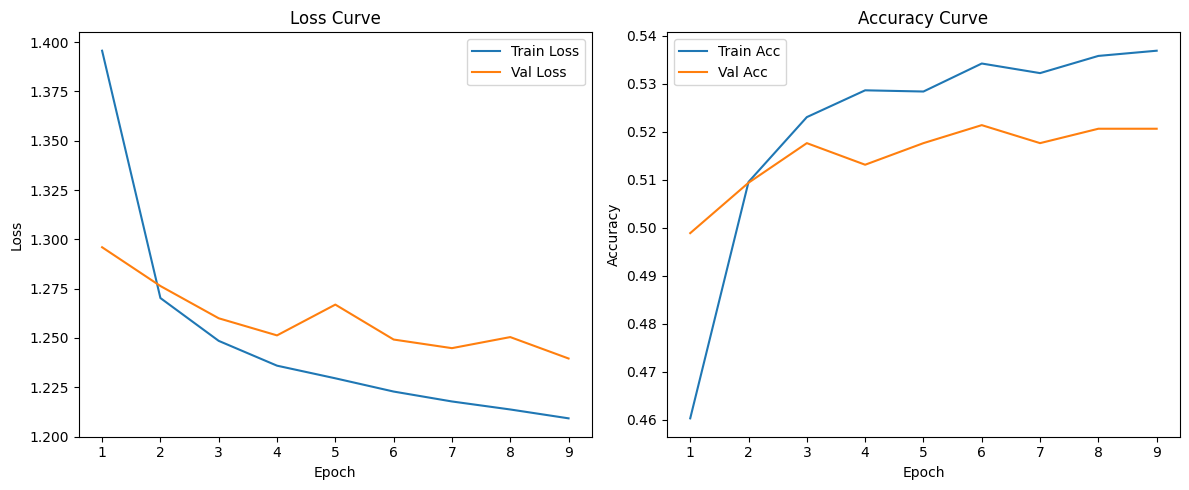

Trying config: {'audio_hidden_dims': (128, 64), 'fc_hidden': 256}
Epoch 1: Train Loss = 1.3434, Acc = 0.4776 | Val Loss = 1.2922, Acc = 0.4891
Best model saved at epoch 1
Epoch 2: Train Loss = 1.2517, Acc = 0.5189 | Val Loss = 1.2688, Acc = 0.5109
Best model saved at epoch 2
Epoch 3: Train Loss = 1.2294, Acc = 0.5313 | Val Loss = 1.2479, Acc = 0.5124
Best model saved at epoch 3
Epoch 4: Train Loss = 1.2174, Acc = 0.5338 | Val Loss = 1.2371, Acc = 0.5228
Best model saved at epoch 4
Epoch 5: Train Loss = 1.2062, Acc = 0.5390 | Val Loss = 1.2624, Acc = 0.5101
Epoch 6: Train Loss = 1.2009, Acc = 0.5417 | Val Loss = 1.2479, Acc = 0.5176
Epoch 7: Train Loss = 1.1931, Acc = 0.5418 | Val Loss = 1.2441, Acc = 0.5311
Best model saved at epoch 7
Epoch 8: Train Loss = 1.1881, Acc = 0.5431 | Val Loss = 1.2459, Acc = 0.5086
Epoch 9: Train Loss = 1.1811, Acc = 0.5466 | Val Loss = 1.2431, Acc = 0.5258
Epoch 10: Train Loss = 1.1780, Acc = 0.5473 | Val Loss = 1.2458, Acc = 0.5213
Early stopping triggere

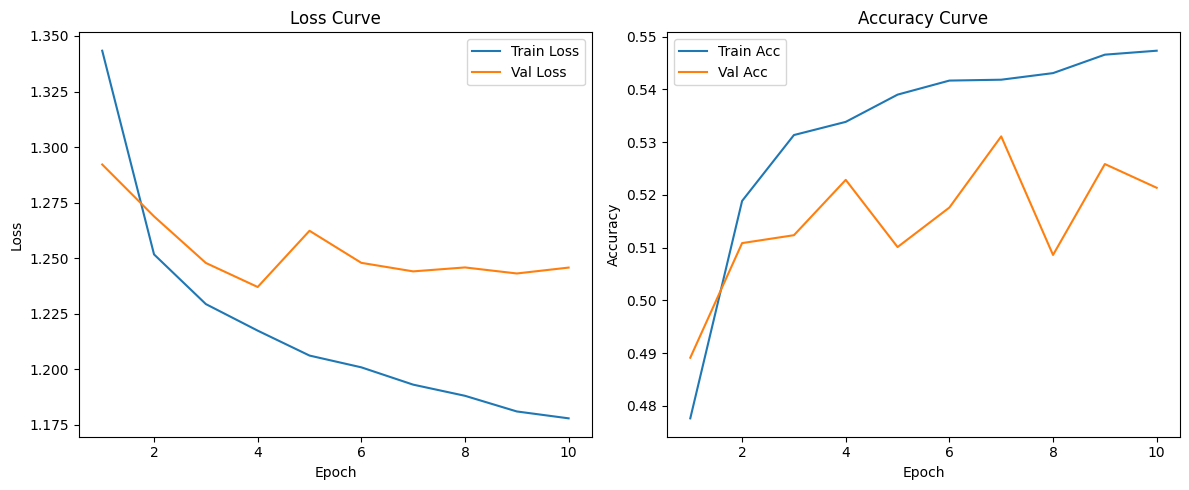

In [13]:
# ==== 多组超参数搜索 ====
# 目标保存目录
save_dir = "/content/drive/MyDrive/CS5242_Song_Prediction/save_model/MLP"
# 创建目录（如果不存在）
os.makedirs(save_dir, exist_ok=True)
EPOCH_MODEL_PATH = os.path.join(save_dir, "epoch_model.pt")
BEST_MODEL_PATH = os.path.join(save_dir, "best_model.pt")

param_grid = [
    { "audio_hidden_dims": (32, 16), "fc_hidden": 64},
    {"audio_hidden_dims": (64, 32), "fc_hidden": 128},
    { "audio_hidden_dims": (128, 64), "fc_hidden": 256}
]

best_val_acc = 0
best_config = None

for config in param_grid:
    print(f"Trying config: {config}")
    model = AUDIO_MLP(
        audio_feat_dim=audio_feat_dim,
        num_classes=num_classes,
        audio_hidden_dims=config["audio_hidden_dims"],
        fc_hidden=config["fc_hidden"]
    ).to(DEVICE)

    history,val_acc = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = config
        torch.save(torch.load(EPOCH_MODEL_PATH), BEST_MODEL_PATH)
        print("Best model updated.")
    plot_metrics(history)


Best Config: {'audio_hidden_dims': (32, 16), 'fc_hidden': 64} | Val Accuracy: 0.5288
Evaluating best model on test set...
Test Loss: 1.2099, Accuracy: 0.5307
Classification Report:
              precision    recall  f1-score   support

         edm       0.44      0.28      0.34       383
       latin       0.73      0.55      0.62       421
         pop       0.42      0.50      0.46       819
         r&b       0.49      0.46      0.47       657
         rap       0.59      0.63      0.61       687
        rock       0.61      0.67      0.63       660

    accuracy                           0.53      3627
   macro avg       0.55      0.51      0.52      3627
weighted avg       0.54      0.53      0.53      3627



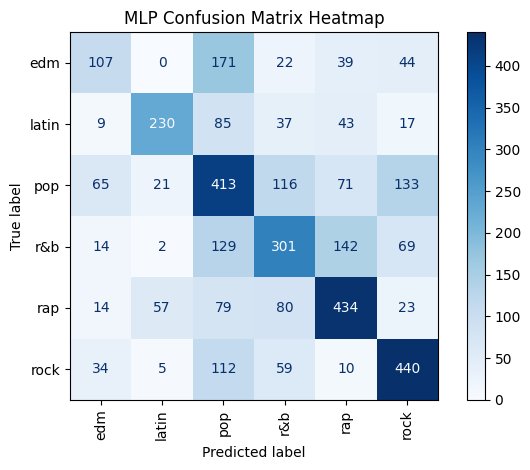

Number of trainable parameters: 2,390
Predictions saved to /content/drive/MyDrive/CS5242_Song_Prediction/MLP.csv


In [12]:
# === 加载最优模型并在测试集上评估 ===

print(f"Best Config: {best_config} | Val Accuracy: {best_val_acc:.4f}")

best_model = AUDIO_MLP(
    audio_feat_dim=audio_feat_dim,
    num_classes=num_classes,
    audio_hidden_dims=best_config["audio_hidden_dims"],
    fc_hidden=best_config["fc_hidden"]
).to(DEVICE)

best_model.load_state_dict(torch.load(BEST_MODEL_PATH))

print("Evaluating best model on test set...")
output_csv_path = "/content/drive/MyDrive/CS5242_Song_Prediction/MLP.csv"
test_model(best_model, test_loader, label_encoder,"MLP Confusion Matrix Heatmap",output_csv_path)
